# Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import dataset

In [2]:
import requests

url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv"
r = requests.get(url)
with open("car_fuel_efficiency.csv", "wb") as f:
    f.write(r.content)

In [3]:
car_df = pd.read_csv("car_fuel_efficiency.csv")

In [4]:
car_df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


# Prep Dataset

In [5]:
car_df_hw = car_df[["engine_displacement", "horsepower", "vehicle_weight", "model_year", "fuel_efficiency_mpg"]]

In [6]:
car_df_hw.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


# Questions

## Question 0 - Fuel Efficinecy MPG Distribution

Based on the below plot:
- The distribution appears normal with maybe some slight, very slight right tail

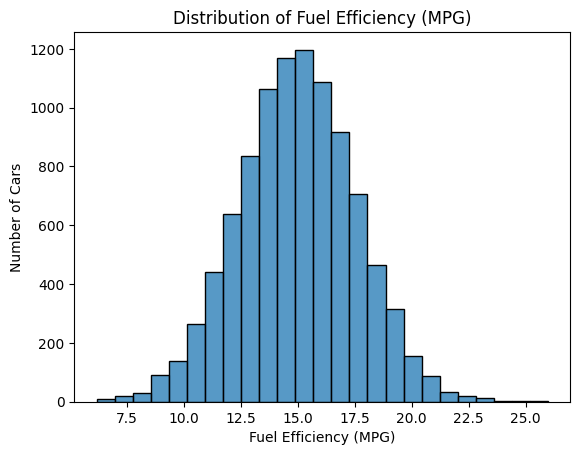

In [7]:
sns.histplot(car_df_hw.fuel_efficiency_mpg, bins=25)#, kde=True)
plt.title("Distribution of Fuel Efficiency (MPG)")
plt.xlabel("Fuel Efficiency (MPG)")
plt.ylabel("Number of Cars")
plt.show()

# Q1 - Which column has missing values?

The below shows that **Horsepower** has missing values

In [8]:
missing_counts = car_df_hw.isnull().sum()
print(missing_counts)

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64


# Q2 - What's the median (50% percentile) for variable 'horsepower'?

In [9]:
float(car_df_hw.horsepower.median())

149.0

# Q3 - 0 Fill or Mean Fill

## Split Dataset Into Train-Validation-Test

- Train = 60%
- Validation = 20%
- Test = 20%

In [10]:
np.random.seed(42)

n = len(car_df_hw)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = car_df_hw.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()


y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

# Remove target from features
del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']


In [11]:
print(n)

9704


In [12]:
print(len(df_train), len(df_val), len(df_test))

5824 1940 1940


### Linear Regression Function

In [13]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [14]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

### Prep Features

In [15]:
base = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']

#### Use Zero To Fill Missing

In [16]:
# --- Option A: Fill missing horsepower with 0
def prepare_X_zero(df):
    df_num = df[base].copy()
    df_num = df_num.fillna(0)
    return df_num.values

In [17]:
## Train Test For 0

X_train_0 = prepare_X_zero(df_train)
X_val_0 = prepare_X_zero(df_val)

w0_0, w_0 = train_linear_regression(X_train_0, y_train)
y_pred_0 = w0_0 + X_val_0.dot(w_0)
rmse_0 = rmse(y_val, y_pred_0)

#### Use Mean To Fill Missing

In [18]:
# --- Option B: Fill missing horsepower with mean
hp_mean = df_train['horsepower'].mean()

def prepare_X_mean(df):
    df_num = df[base].copy()
    df_num['horsepower'] = df_num['horsepower'].fillna(hp_mean)
    return df_num.values


In [19]:
## Train Test For Mean

X_train_mean = prepare_X_mean(df_train)
X_val_mean = prepare_X_mean(df_val)

w0_mean, w_mean = train_linear_regression(X_train_mean, y_train)
y_pred_mean = w0_mean + X_val_mean.dot(w_mean)
rmse_mean = rmse(y_val, y_pred_mean)

In [20]:
print("RMSE 0 Fill:", rmse_0)
print("RMSE MEAN fill:", rmse_mean)

RMSE 0 Fill: 0.5173782638841185
RMSE MEAN fill: 0.4635965042344029


## Q3 - ANSWER

- A LOWER RMSE is better.
- That means that the **MEAN fill** works better than the *0 fill*.

# Q4 - Regularized Linear Model

In [21]:
def prepare_X(df):
    df = df.copy()
    
    # Select only the base features and fill missing values with 0
    df_num = df[base].fillna(0)
    
    # Convert to NumPy array for linear regression
    X = df_num.values
    
    return X

In [22]:
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

## Try different regularization values

In [23]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [24]:
X_train = prepare_X(df_train)

In [25]:
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    print('%6s RMSE: %.8f' % (r, score))

     0 RMSE: 0.51737826
  0.01 RMSE: 0.51711155
   0.1 RMSE: 0.51875251
     1 RMSE: 0.52223488
     5 RMSE: 0.52289161
    10 RMSE: 0.52298130
   100 RMSE: 0.52306362


## Q4 - ANSWER

- A LOWER RMSE is better.
- That means that the **0.01 RMSE** works best by as slight margin.

# Q5 - Best Seed and ST dev

In [29]:
rmse_scores = []

for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    # ---------------------------
    # Split data (same logic as Q3)
    # ---------------------------
    np.random.seed(seed)
    
    n = len(car_df_hw)
    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)
    
    idx = np.arange(n)
    np.random.shuffle(idx)
    
    df_shuffled = car_df_hw.iloc[idx]
    
    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()
    
    y_train = df_train.fuel_efficiency_mpg.values
    y_val = df_val.fuel_efficiency_mpg.values
    
    del df_train['fuel_efficiency_mpg']
    del df_val['fuel_efficiency_mpg']
    del df_test['fuel_efficiency_mpg']
    
    # ---------------------------
    # Prepare features (fill 0)
    # ---------------------------
    X_train = prepare_X(df_train)
    X_val = prepare_X(df_val)
    
    # ---------------------------
    # Train and evaluate
    # ---------------------------
    w0, w = train_linear_regression(X_train, y_train)
    y_pred = w0 + X_val.dot(w)
    
    score = rmse(y_val, y_pred)
    rmse_scores.append(score)

    print('%6s RMSE: %.8f' % (seed, score))

# ---------------------------
# Compute and report std dev
# ---------------------------
std = np.std(rmse_scores)
print('\nStandard deviation: %.6f' % std)
#print("RMSE scores:", [round(s, 3) for s in rmse_scores])
#print("Standard deviation:", round(std, 3))

     0 RMSE: 0.52065313
     1 RMSE: 0.52133889
     2 RMSE: 0.52280700
     3 RMSE: 0.51595167
     4 RMSE: 0.51091295
     5 RMSE: 0.52834065
     6 RMSE: 0.53139107
     7 RMSE: 0.50906704
     8 RMSE: 0.51473991
     9 RMSE: 0.51318659

Standard deviation: 0.006989


## Q5 - ANSWER

The answer for this question is the Standard Deviation of **0.006**

# Q6 - RMSE For Dataset?

### Split Data

In [30]:
np.random.seed(9)

n = len(car_df_hw)
n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = car_df_hw.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

### Combine Train-Test

In [31]:
df_full_train = pd.concat([df_train, df_val])

y_full_train = df_full_train.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

del df_full_train['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

### Prepare features - fill missing with 0

In [32]:
X_full_train = prepare_X(df_full_train)
X_test = prepare_X(df_test)

### Train regularized linear regression

In [34]:
w0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)

### Predict and evaluate on test set

In [36]:
y_pred = w0 + X_test.dot(w)
score = rmse(y_test, y_pred)

print("Test RMSE: %.4f" % score)

Test RMSE: 0.5156


## Q6 - ANSWER

Test RMSE: 0.5156